<a href="https://colab.research.google.com/github/davidmerwin/Google_Quantum_Deep_Learning_Training/blob/main/copy_of_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Create some qubits.
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# Create operations using the Sycamore gate, which is supported by the Sycamore device.
# However, create operations for both adjacent and non-adjacent qubit pairs.
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# A working circuit for the Sycamore device raises no issues.
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# A circuit using invalid operations.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(5, 6), cirq.GridQubit(4, 5)).


##### Copyright 2022 The Cirq Developers

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Cirq basics

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/start/basics"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/start/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/start/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/start/basics.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This tutorial will teach the basics of how to use Cirq. It will walk through how to use qubits, gates, and operations to create and simulate your first quantum circuit using Cirq.  It will briefly introduce devices, unitary matrices, decompositions, and transformers as well.

This tutorial isn’t a quantum computing 101 tutorial: it assumes familiarity of quantum computing at about the level of the textbook “Quantum Computation and Quantum Information” by Nielsen and Chuang.

For more in-depth examples of quantum algorithms and experiments, see [Experiments](../experiments).

To begin, please follow the instructions for [installing Cirq](./install.md).

In [ ]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

import cirq_google

## Qubits

The first part of creating a quantum circuit is to define a set of qubits (also known as a quantum register) to act on.

Cirq has three main ways of defining qubits:

*   `cirq.NamedQubit`: used to label qubits by an abstract name.
*   `cirq.LineQubit`: qubits labelled by number in a linear array.
*   `cirq.GridQubit`: qubits labelled by two numbers in a rectangular lattice.

Here are some examples of defining each type of qubit.

In [ ]:
# Using named qubits can be useful for abstract algorithms
# as well as algorithms not yet mapped onto hardware.
q0 = cirq.NamedQubit('source')
q1 = cirq.NamedQubit('target')

# Line qubits can be created individually
q3 = cirq.LineQubit(3)

# Or created in a range
# This will create LineQubit(0), LineQubit(1), LineQubit(2)
q0, q1, q2 = cirq.LineQubit.range(3)

# Grid Qubits can also be referenced individually
q4_5 = cirq.GridQubit(4, 5)

# Or created in bulk in a square
# This will create 16 qubits from (0,0) to (3,3)
qubits = cirq.GridQubit.square(4)

There are also pre-packaged sets of qubits called [Devices](../hardware/devices.ipynb).  These are qubits along with a set of rules for how they can be used.  A `cirq.Device` can be used to ensure that two-qubit gates are only applied to qubits that are adjacent in the hardware, and other constraints.  The following example will use the `cirq_google.Sycamore` device that comes with cirq.  It is a diamond-shaped grid with 54 qubits that mimics early hardware released by Google.

In [ ]:
print(cirq_google.Sycamore)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

## Gates and operations

The next step is to use the qubits to create operations that can be used in the circuit.  Cirq has two concepts that are important to understand here:

*   A `Gate` is an effect that can be applied to a set of qubits.  
*   An `Operation` is a gate applied to a set of qubits.

For instance, `cirq.H` is the quantum [Hadamard](https://en.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_(H)_gate) and is a `Gate` object.  `cirq.H(cirq.LineQubit(1))` is an `Operation` object and is the Hadamard gate applied to a specific qubit (line qubit number 1).

Many textbook gates are included within cirq.  `cirq.X`, `cirq.Y`, and `cirq.Z` refer to the single-qubit Pauli gates.  `cirq.CZ`, `cirq.CNOT`, `cirq.SWAP` are a few of the common two-qubit gates.  `cirq.measure` is a macro to apply a `MeasurementGate` to a set of qubits.  You can find more, as well as instructions on how to create your own custom gates, on the [Gates documentation](../build/gates.ipynb) page.

Here are some examples of operations that can be performed on gates and operations:

In [ ]:
# Example gates
cnot_gate = cirq.CNOT
pauli_z = cirq.Z

# Use exponentiation to get square root gates.
sqrt_x_gate = cirq.X**0.5

# Some gates can also take parameters
sqrt_sqrt_y = cirq.YPowGate(exponent=0.25)

# Create two qubits at once, in a line.
q0, q1 = cirq.LineQubit.range(2)

# Example operations
z_op = cirq.Z(q0)
not_op = cirq.CNOT(q0, q1)
sqrt_iswap_op = cirq.SQRT_ISWAP(q0, q1)

# You can also use the gates you specified earlier.
cnot_op = cnot_gate(q0, q1)
pauli_z_op = pauli_z(q0)
sqrt_x_op = sqrt_x_gate(q0)
sqrt_sqrt_y_op = sqrt_sqrt_y(q0)

## Circuits and moments

You are now ready to construct a quantum circuit.  A `Circuit` is a collection of `Moment`s. A `Moment` is a collection of `Operation`s that all act during the same abstract time slice.  Each `Operation` must be applied to a disjoint set of qubits compared to each of the other `Operation`s in the `Moment`.  A `Moment` can be thought of as a vertical slice of a quantum circuit diagram.

Circuits can be constructed in several different ways.  By default, Cirq will attempt to slide your operation into the earliest possible `Moment` when you insert it. You can use the append function in two ways:

By appending each operation one-by-one:

In [ ]:
circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(3)
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
print(circuit)

0: ───H───

1: ───H───

2: ───H───


Or by appending some iterable of operations. A preconstructed list works:

In [ ]:
circuit = cirq.Circuit()
ops = [cirq.H(q) for q in cirq.LineQubit.range(3)]
circuit.append(ops)
print(circuit)

0: ───H───

1: ───H───

2: ───H───


A generator that yields operations also works. This syntax will be used often in documentation, and works both with the `cirq.Circuit()` initializer and the `cirq.Circuit.append()` function.

In [ ]:
# Append with generator
circuit = cirq.Circuit()
circuit.append(cirq.H(q) for q in cirq.LineQubit.range(3))
print(circuit)
# Initializer with generator
print(cirq.Circuit(cirq.H(q) for q in cirq.LineQubit.range(3)))

0: ───H───

1: ───H───

2: ───H───
0: ───H───

1: ───H───

2: ───H───


Note that all of the Hadamard gates are pushed as far left as possible, and put into the same Moment since none overlap.

If your operations are applied to the same qubits, they will be put in sequential, insertion-ordered moments. In the following example, the two-qubit gates overlap, and are placed in consecutive moments.

In [ ]:
print(cirq.Circuit(cirq.SWAP(q, q + 1) for q in cirq.LineQubit.range(3)))

0: ───×───────────
      │
1: ───×───×───────
          │
2: ───────×───×───
              │
3: ───────────×───


Sometimes, you may not want Cirq to automatically shift operations all the way to the left.  To construct a circuit without doing this, you can create the circuit moment-by-moment or use a different `InsertStrategy`, explained more in the [Circuit documentation](../build/circuits.ipynb).

In [ ]:
# Creates each gate in a separate moment by passing an iterable of Moments instead of Operations.
print(cirq.Circuit(cirq.Moment([cirq.H(q)]) for q in cirq.LineQubit.range(3)))

0: ───H───────────

1: ───────H───────

2: ───────────H───


### Circuits and devices

One important consideration when using real quantum devices is that there are often constraints on circuits that are able to be run on the hardware.  `Device` objects specify these constraints and can be used to validate your circuit to make sure that it contains no illegal operations. For more information on what constraints `Device` objects can specify and how to use them, see the [Devices](../hardware/devices.ipynb) page.

The following example demonstrates this with the Sycamore Device:

In [ ]:
# Create some qubits.
q0 = cirq.GridQubit(5, 6)
q1 = cirq.GridQubit(5, 5)
q2 = cirq.GridQubit(4, 5)

# Create operations using the Sycamore gate, which is supported by the Sycamore device.
# However, create operations for both adjacent and non-adjacent qubit pairs.
adjacent_op = cirq_google.SYC(q0, q1)
nonadjacent_op = cirq_google.SYC(q0, q2)

# A working circuit for the Sycamore device raises no issues.
working_circuit = cirq.Circuit()
working_circuit.append(adjacent_op)
valid = cirq_google.Sycamore.validate_circuit(working_circuit)

# A circuit using invalid operations.
bad_circuit = cirq.Circuit()
bad_circuit.append(nonadjacent_op)
try:
    cirq_google.Sycamore.validate_circuit(bad_circuit)
except ValueError as e:
    print(e)

Qubit pair is not valid on device: (cirq.GridQubit(5, 6), cirq.GridQubit(4, 5)).


## Simulation

The results of the application of a quantum circuit can be calculated by a `Simulator`.  Cirq comes bundled with a simulator that can calculate the results of circuits up to about a limit of 20 qubits.  It can be initialized with `cirq.Simulator()`.

There are two different approaches to using a simulator:

*   `simulate()`:  When classically simulating a circuit, a simulator can directly access and view the resulting wave function.  This is useful for debugging, learning, and understanding how circuits will function.  
*   `run()`:  When using actual quantum devices, we can only access the end result of a computation and must sample the results to get a distribution of results.  Running the simulator as a sampler mimics this behavior and only returns bit strings as output.

Next simulate a 2-qubit "Bell State":

In [ ]:
# Create a circuit to generate a Bell State:
# 1/sqrt(2) * ( |00⟩ + |11⟩ )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0, q1))

# Initialize Simulator
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(bell_circuit)
print(results)

# For sampling, we need to add a measurement at the end
bell_circuit.append(cirq.measure(q0, q1, key='result'))

# Sample the circuit
samples = s.run(bell_circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩

phase:
output vector: |⟩


### Virtual Machine Simulation

Cirq also provides the [Quantum Virtual Machine](../simulate/quantum_virtual_machine.ipynb), which is a simulated virtual version of quantum hardware devices. It consists of two primary components:
1. A [virtual Engine interface](../simulate/virtual_engine_interface.ipynb) that enables you to verify and run circuits with the same interface that quantum hardware would have.
2. A set of [noise models](../noise/representing_noise.ipynb) that try to realistically replicate the noise present in actual Google quantum hardware devices.

The QVM is intended to serve as a replacement for the Google quantum hardware, in two cases:
1. Running your circuit on a QVM can give an approximation of how your circuit runs under the influence of hardware-like noise. This can be useful to help you reconfigure or change your circuit to be less impacted by noise when run on actual quantum hardware.
2. During the preparation process before running your circuit(s) on hardware, you can seamlessly use a QVM to test that your workflow or pipeline works before eventually switching to the nearly-identical hardware interface.

Read more about the QVM and its uses in the [Quantum Virtual Machine](../simulate/quantum_virtual_machine.ipynb) page, or just start using it with the [QVM Creation Template](../simulate/qvm_builder_code.ipynb) page.

## Visualizing Results

When you use `run()` to get a sample distribution of measurements, you can directly graph the simulated samples as a histogram with `cirq.plot_state_histogram`.

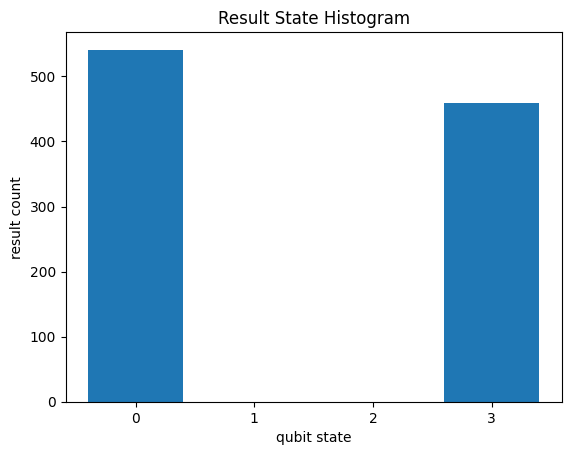

In [ ]:
import matplotlib.pyplot as plt

cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

However, this histogram has some empty qubit states, which may become problematic if you work with more qubits. To graph sparse sampled data, first get the `Counts` from your results with its `histogram()` function, and pass that to `cirq.plot_state_histogram`. By collecting the results into counts, all the qubit states that were never seen are ignored.

Counter({0: 541, 3: 459})


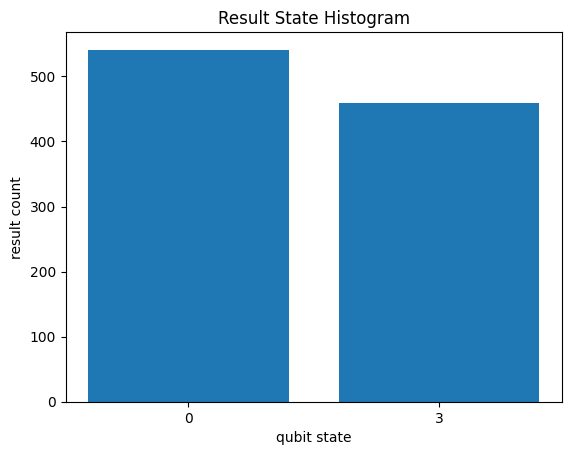

In [ ]:
# Pull of histogram counts from the result data structure
counts = samples.histogram(key='result')
print(counts)

# Graph the histogram counts instead of the results
cirq.plot_state_histogram(counts, plt.subplot())
plt.show()

A histogram over the states that were actually observed can often be more useful when analyzing results. To learn more about the available options for creating result histograms, see the [State Histograms](../simulate/state_histograms.ipynb) page.

### Using parameter sweeps

Cirq circuits allow for gates to have symbols as free parameters within the circuit.  This is especially useful for variational algorithms, which vary parameters within the circuit in order to optimize a cost function, but it can be useful in a variety of circumstances.

For parameters, Cirq uses the library `sympy` to add `sympy.Symbol` as parameters to gates and operations.  

Once the circuit is complete, you can fill in the possible values of each of these parameters with a `Sweep`.  There are several possibilities that can be used as a sweep:

*   `cirq.Points`: A list of manually specified values for one specific symbol as a sequence of floats.
*   `cirq.Linspace`: A linear sweep from a starting value to an ending value.
*   `cirq.ListSweep`: A list of manually specified values for several different symbols, specified as a list of dictionaries.
*   `cirq.Zip` and `cirq.Product`: Sweeps can be combined list-wise by zipping them together or through their Cartesian product.

A parameterized circuit and sweep together can be run using the simulator or other sampler by changing `run()` to `run_sweep()` and adding the sweep as a parameter.

Here is an example of sweeping an exponent of a X gate:

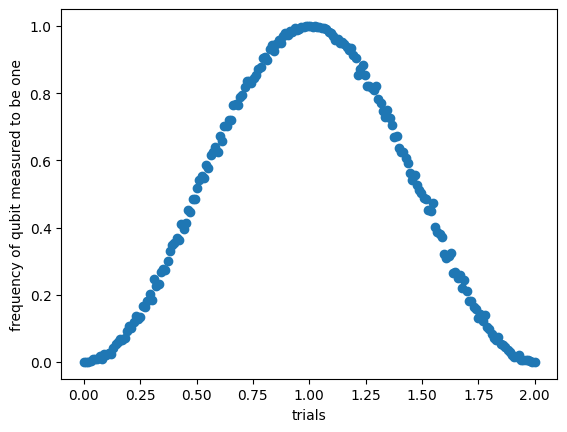

In [ ]:
import sympy

# Perform an X gate with variable exponent
q = cirq.GridQubit(1, 1)
circuit = cirq.Circuit(cirq.X(q) ** sympy.Symbol('t'), cirq.measure(q, key='m'))

# Sweep exponent from zero (off) to one (on) and back to two (off)
param_sweep = cirq.Linspace('t', start=0, stop=2, length=200)

# Simulate the sweep
s = cirq.Simulator()
trials = s.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x_data = [trial.params['t'] for trial in trials]
y_data = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter('t', 'p', data={'t': x_data, 'p': y_data})
plt.xlabel("trials")
plt.ylabel("frequency of qubit measured to be one")
plt.show()

## Unitary matrices and decompositions

Many quantum operations have unitary matrix representations.  This matrix can be accessed by applying `cirq.unitary(operation)` to that `operation`.  This can be applied to gates, operations, and circuits that support this protocol and will return the unitary matrix that represents the object. See [Protocols](../build/protocols.ipynb) for more about this and other protocols.

In [ ]:
print('Unitary of the X gate')
print(cirq.unitary(cirq.X))

print('Unitary of SWAP operator on two qubits.')
q0, q1 = cirq.LineQubit.range(2)
print(cirq.unitary(cirq.SWAP(q0, q1)))

print('Unitary of a sample circuit')
print(cirq.unitary(cirq.Circuit(cirq.X(q0), cirq.SWAP(q0, q1))))

Unitary of the X gate
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Unitary of SWAP operator on two qubits.
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Unitary of a sample circuit
[[0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


### Decompositions

Many gates can be decomposed into an equivalent circuit with simpler operations and gates.  This is called decomposition and can be accomplished with the `cirq.decompose` protocol.  

For instance, a Hadamard H gate can be decomposed into X and Y gates:

In [ ]:
print(cirq.decompose(cirq.H(cirq.LineQubit(0))))

[(cirq.Y**0.5).on(cirq.LineQubit(0)), cirq.XPowGate(global_shift=-0.25).on(cirq.LineQubit(0))]


Another example is the 3-qubit Toffoli gate, which is equivalent to a controlled-controlled-X gate.  Many devices do not support three qubit gates, so it is important to decompose them into one and two qubit gates.

In [ ]:
q0, q1, q2 = cirq.LineQubit.range(3)
print(cirq.Circuit(cirq.decompose(cirq.TOFFOLI(q0, q1, q2))))

0: ───T────────────────@─────────────────────────────────@─────────────────────────────@────────────────────────────@───────────────────────────────────────
                       │                                 │                             │                            │
1: ───T───────Y^-0.5───@───Y^0.5────@───T^-1────Y^-0.5───@────────Y^0.5───@───Y^-0.5───@──────Y^0.5────@───Y^-0.5───@──────Y^0.5────@───────────────────────
                                    │                                     │                            │                            │
2: ───Y^0.5───X────────T───Y^-0.5───@───Y^0.5───T────────Y^-0.5───────────@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5────T^-1───Y^-0.5───@───Y^0.5───Y^0.5───X───


The above decomposes the Toffoli into a simpler set of one-qubit gates and two-qubit CZ gates at the cost of lengthening the circuit considerably.

### Transformers

The last concept in this tutorial is the transformer.  A transformer can take a circuit and modify it.  Usually, this will entail combining or modifying operations to make it more efficient and shorter, though a transformer can, in theory, do any sort of circuit manipulation.

For example, the `cirq.merge_single_qubit_gates_to_phxz` transformer will take consecutive single-qubit operations and merge them into a single `PhasedXZ` operation.

In [ ]:
q = cirq.GridQubit(1, 1)
c = cirq.Circuit(cirq.X(q) ** 0.25, cirq.Y(q) ** 0.25, cirq.Z(q) ** 0.25)
print(c)
c = cirq.merge_single_qubit_gates_to_phxz(c)
print(c)

(1, 1): ───X^0.25───Y^0.25───T───
(1, 1): ───PhXZ(a=0.304,x=0.333,z=0.142)───


Other transformers can assist in transforming a circuit into operations that are native operations on specific hardware devices.  You can find more about transformers and how to create your own in [Transformers](../transform/transformers.ipynb).

## Next steps

After completing this tutorial, you should be able to use gates and operations to construct your own quantum circuits, to simulate them, and to use sweeps.

There is much more to learn and try out for those who are interested:

* Learn about the variety of [Gates](../build/gates.ipynb) available in cirq and more about the different ways to construct [Circuits](../build/circuits.ipynb).
* Learn more about [Simulations](../simulate/simulation.ipynb) and how it works.
* Learn about [Noise](../noise) and how to utilize multi-level systems using [Qudits](../build/qudits.ipynb).
* Dive into some [Experiments](../experiments) and some in-depth tutorials of how to use cirq.

Also, join our [cirq-announce mailing list](https://groups.google.com/forum/#!forum/cirq-announce) to hear about changes and releases or go to the [Cirq GitHub repository](https://github.com/quantumlib/Cirq/) to file issues.